In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import json
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import geometry
from quetzal.model import stepmodel
from quetzal.engine.engine import od_volume_from_zones
from syspy.skims import skims
from quetzal.io import excel

In [3]:
model_path = '../model/' + scenario + '/'
input_path = '../input/'
output_path = '../output/'

In [17]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

# OD set sampling

## Needs zones

## Saves OD set of desired size and with desired zones

In [5]:
# Load zones
sm = stepmodel.read_json(model_path + 'de_zones')
sm.zones.sort_index(inplace=True)

## Generate sampling probabilities

A simple gravity model based on zone populations and distance between zones calculates base case OD volumes, which are used as probabilities for the sampling process.

In [6]:
# Generate generic travel volumes from a distance-based gravity model
sm.zones['emission'] = sm.zones['population']
sm.zones['attraction'] = sm.zones['population']
power = 3 # gravity model exponent
distance = skims.euclidean(sm.zones, coordinates_unit=sm.coordinates_unit, intrazonal=False)
distance = distance.set_index(['origin', 'destination'])['euclidean_distance'].unstack('destination')
deterrence_matrix = np.power(distance.replace(0, 1e12), -power)
volumes = od_volume_from_zones(sm.zones, deterrence_matrix)

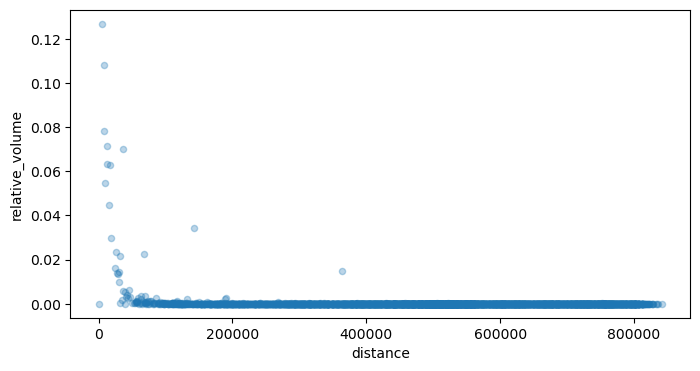

In [7]:
# Plot volume distribution over distance for first zone
# The relative volume is volumes / origin zone's population
if manual:
    vols = volumes.merge(sm.zones[['FID', 'population']], how='left', left_on='origin', right_on='FID')
    vols['relative_volume'] = vols['volume'] / vols['population']
    vols = vols.merge(distance.stack().rename('distance').reset_index(),
                      how='left', on=['origin', 'destination'])
    vols.head(len(sm.zones)).plot.scatter(x='distance', y='relative_volume', alpha=.3, figsize=(8,4))

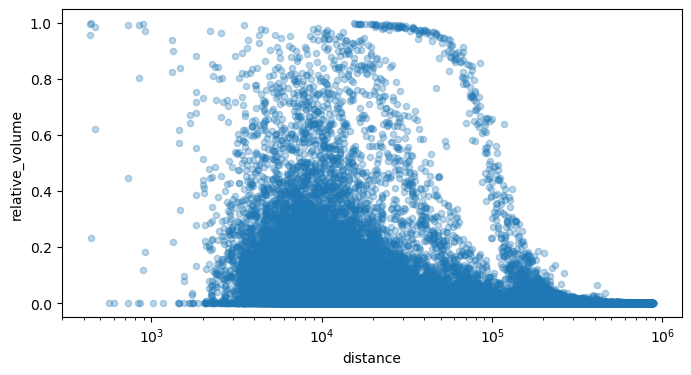

In [8]:
# Plot total volume distribution over distance
if manual:
    vols.plot.scatter(x='distance', y='relative_volume', alpha=0.3, logx=True, figsize=(8,4))

In [9]:
full_sum = volumes['volume'].sum()
full_sum

83146028.99999985

## Sparsify the OD set

Reduce the number of OD pairs to a sample that includes the most relevant connections, as well as an equal distribution of distances, and the given zones in the scenario parameters.

In [10]:
volumes.set_index(['origin', 'destination'], inplace=True)

In [11]:
sample_size = params['general']['od_sparse_sample']
# Set a stable seed, generating the same OD set in every run
np.random.seed(42)

In [12]:
# Choice probabilities of OD pairs weighted by trip volumes
# That ensures having the most important/intensive OD pairs in the sample
od_probabilities = volumes['volume'] / full_sum
sample = np.random.choice(a=volumes.index,
                          size=sample_size,
                          p=od_probabilities)

In [13]:
# Add a sample without volume weighting for the right distance distribution
# (high volumes are usually short-distance connections)
sample2 = np.random.choice(a=volumes.index, size=sample_size)

In [18]:
# Add zones specified in scenario parameters
add_zones = params['general']['include_zones']
add_od_pairs = []
if isinstance(add_zones, str):
    add_zones = [z.strip() for z in add_zones.split(';')]
    if pd.api.types.is_numeric_dtype(sm.zones['FID']):
        add_zones = [int(z) for z in add_zones]
    add_od_pairs = [(o,d) for o in add_zones for d in add_zones]

In [19]:
# unite them all and remove duplicates
od_set = set(sample) | set(sample2) | set(add_od_pairs)
len(od_set)

202064

In [20]:
# Remove inner-zonal connections
od_set = od_set - set([od for od in od_set if od[0] == od[1]])
len(od_set)

202018

In [ ]:
# Sketch coverage
if False:
    lines = [geometry.LineString([(sm.zones.loc[o,'lat'], sm.zones.loc[o,'lon']),
                                  (sm.zones.loc[d,'lat'], sm.zones.loc[d,'lon'])
                                 ]) for (o,d) in od_set]
    lines_gdf = gpd.GeoDataFrame(geometry=lines, crs=sm.epsg)
    lines_gdf.plot(alpha=0.005, ax=gpd.GeoDataFrame(sm.zones).plot(
        color='green', alpha=0.1, figsize=(12,12)))

<Axes: xlabel='distance', ylabel='relative_volume'>

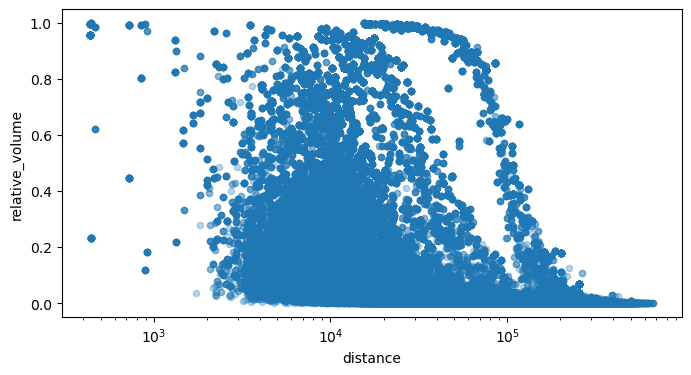

In [31]:
# Compare volume distribution to above
if manual:
    vols.set_index(['origin', 'destination']).loc[sample].plot.scatter(
        x='distance', y='relative_volume', alpha=0.3, logx=True, figsize=(8,4))

## Save OD set

In [32]:
with open(model_path + 'od_set.json', 'w') as file:
    json.dump(list(od_set), file)